In [ ]:
!pip -q install -U "pydantic==2.12.3"
!pip -q install -U langgraph langchain-core networkx matplotlib
!pip -q install -U langgraph-checkpoint-sqlite

import os
import json
import uuid
import sqlite3
from datetime import datetime, timezone
from typing import Any, Dict, List, Literal, Optional, Tuple

from pydantic import BaseModel, Field

import networkx as nx
import matplotlib.pyplot as plt

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver


Role = Literal["planner", "executor", "validator", "user", "system"]
MsgType = Literal["task", "plan", "result", "validation", "error", "control"]

class ACPMessage(BaseModel):
    msg_id: str = Field(default_factory=lambda: str(uuid.uuid4()))
    ts: str = Field(default_factory=lambda: datetime.now(timezone.utc).isoformat().replace("+00:00", "Z"))
    sender: Role
    receiver: Role
    msg_type: MsgType
    content: str
    meta: Dict[str, Any] = Field(default_factory=dict)
    trace: Dict[str, Any] = Field(default_factory=dict)

def acp_log_path() -> str:
    os.makedirs("acp_logs", exist_ok=True)
    return os.path.join("acp_logs", "acp_messages.jsonl")

def append_acp_log(m: ACPMessage) -> None:
    with open(acp_log_path(), "a", encoding="utf-8") as f:
        f.write(m.model_dump_json() + "\n")

In [ ]:
class BusState(BaseModel):
    goal: str = ""
    done: bool = False
    errors: List[str] = Field(default_factory=list)
    mailbox: List[ACPMessage] = Field(default_factory=list)
    edges: List[Tuple[str, str, str]] = Field(default_factory=list)
    active_role: Role = "user"
    step: int = 0


def bus_update(
    state: BusState,
    sender: Role,
    receiver: Role,
    msg_type: MsgType,
    content: str,
    meta: Optional[Dict[str, Any]] = None,
    trace: Optional[Dict[str, Any]] = None,
) -> Dict[str, Any]:
    m = ACPMessage(
        sender=sender,
        receiver=receiver,
        msg_type=msg_type,
        content=content,
        meta=meta or {},
        trace=trace or {},
    )
    append_acp_log(m)
    return {
        "goal": state.goal,
        "done": state.done,
        "errors": state.errors,
        "mailbox": state.mailbox + [m],
        "edges": state.edges + [(sender, receiver, msg_type)],
        "active_role": receiver,
        "step": state.step + 1,
    }

In [ ]:
def planner_agent(state_dict: Dict[str, Any]) -> Dict[str, Any]:
    state = BusState.model_validate(state_dict)
    goal = state.goal.strip()
    if not goal:
        return bus_update(state, "planner", "validator", "error", "No goal provided.", meta={"reason": "empty_goal"})
    plan = [
        "Interpret the goal and extract requirements.",
        "Decide an execution strategy with clear outputs.",
        "Ask Executor to produce the result.",
        "Ask Validator to check correctness + completeness.",
    ]
    plan_text = "\n".join([f"{i+1}. {p}" for i, p in enumerate(plan)])
    return bus_update(
        state,
        "planner",
        "executor",
        "plan",
        plan_text,
        meta={"goal": goal, "plan_steps": len(plan)},
        trace={"policy": "deterministic_planner_v1"},
    )


def executor_agent(state_dict: Dict[str, Any]) -> Dict[str, Any]:
    state = BusState.model_validate(state_dict)
    goal = state.goal.strip()
    latest_plan = None
    for m in reversed(state.mailbox):
        if m.receiver == "executor" and m.msg_type == "plan":
            latest_plan = m.content
            break
    result = {
        "goal": goal,
        "assumptions": [
            "We can produce a concise, actionable output.",
            "We can validate via rule-based checks.",
        ],
        "output": f"Executed task for goal: {goal}",
        "deliverables": [
            "A clear summary",
            "A step-by-step action list",
            "Any constraints and edge cases",
        ],
        "plan_seen": bool(latest_plan),
    }
    result_text = json.dumps(result, indent=2)
    return bus_update(
        state,
        "executor",
        "validator",
        "result",
        result_text,
        meta={"artifact_type": "json", "bytes": len(result_text.encode("utf-8"))},
        trace={"policy": "deterministic_executor_v1"},
    )

In [ ]:
def validator_agent(state_dict: Dict[str, Any]) -> Dict[str, Any]:
    state = BusState.model_validate(state_dict)
    goal = state.goal.strip()
    latest_result = None
    for m in reversed(state.mailbox):
        if m.receiver == "validator" and m.msg_type in ("result", "error"):
            latest_result = m
            break
    if latest_result is None:
        upd = bus_update(state, "validator", "planner", "error", "No result to validate.", meta={"reason": "missing_result"})
        upd["done"] = True
        upd["errors"] = state.errors + ["missing_result"]
        return upd
    if latest_result.msg_type == "error":
        upd = bus_update(
            state,
            "validator",
            "planner",
            "validation",
            f"Validation failed because upstream error occurred: {latest_result.content}",
            meta={"status": "fail"},
        )
        upd["done"] = True
        upd["errors"] = state.errors + [latest_result.content]
        return upd
    try:
        parsed = json.loads(latest_result.content)
    except Exception as e:
        upd = bus_update(
            state,
            "validator",
            "planner",
            "validation",
            f"Result is not valid JSON: {e}",
            meta={"status": "fail"},
        )
        upd["done"] = True
        upd["errors"] = state.errors + [f"invalid_json: {e}"]
        return upd
    issues = []
    if parsed.get("goal") != goal:
        issues.append("Result.goal does not match input goal.")
    if "deliverables" not in parsed or not isinstance(parsed["deliverables"], list) or len(parsed["deliverables"]) == 0:
        issues.append("Missing or empty deliverables list.")
    if issues:
        upd = bus_update(
            state,
            "validator",
            "planner",
            "validation",
            "Validation failed:\n- " + "\n- ".join(issues),
            meta={"status": "fail", "issues": issues},
        )
        upd["done"] = True
        upd["errors"] = state.errors + issues
        return upd
    upd = bus_update(
        state,
        "validator",
        "user",
        "validation",
        "Validation passed ✅ Result looks consistent and complete.",
        meta={"status": "pass"},
    )
    upd["done"] = True
    upd["errors"] = state.errors
    return upd


def route_next(state_dict: Dict[str, Any]) -> str:
    if state_dict.get("done", False):
        return END
    role = state_dict.get("active_role", "user")
    if role == "planner":
        return "planner"
    if role == "executor":
        return "executor"
    if role == "validator":
        return "validator"
    return END

Done: True
Steps: 3
Errors: []

Last 5 messages:
- [plan] planner -> executor: 1. Interpret the goal and extract requirements.
2. Decide an execution strategy 
- [result] executor -> validator: {
  "goal": "Design an ACP-style message bus where planner/executor/validator co
- [validation] validator -> user: Validation passed ✅ Result looks consistent and complete.

Checkpoint keys: ['v', 'ts', 'id', 'channel_values', 'channel_versions', 'versions_seen', 'updated_channels']
channel_values keys: ['__root__']
state keys: []

Persisted step (best-effort): NOT_FOUND
Persisted active_role (best-effort): NOT_FOUND

ACP logs: acp_logs/acp_messages.jsonl
Checkpoint DB: checkpoints/langgraph_bus.sqlite


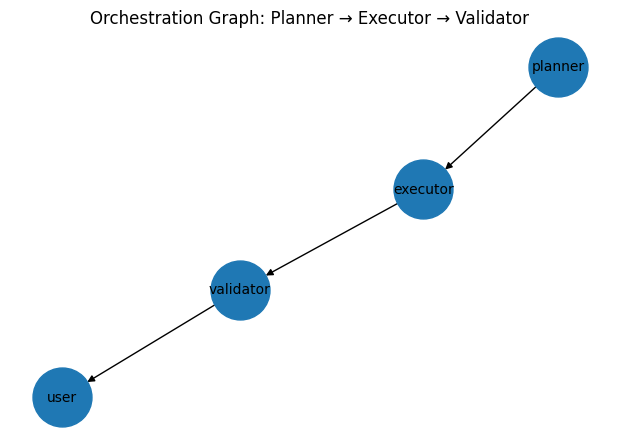

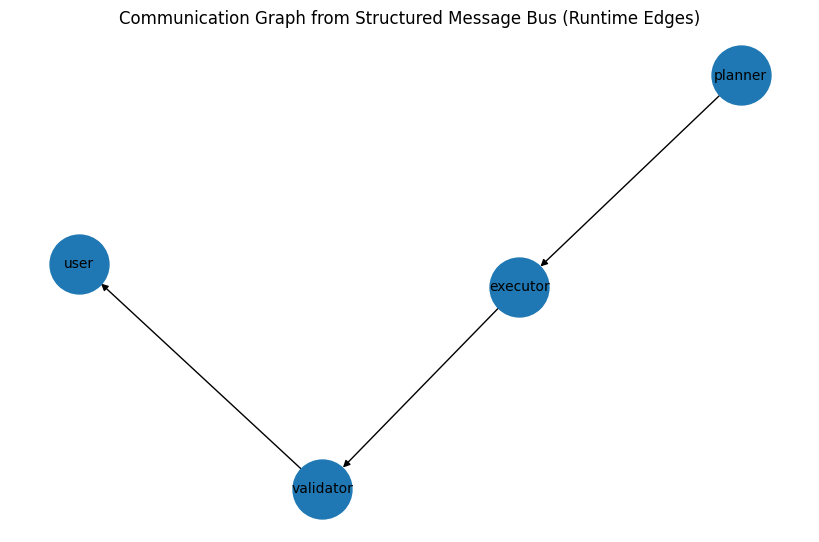


Last ACP log entries:
      plan | planner -> executor | 2026-02-06T20:29:43.088384Z
    result | executor -> validator | 2026-02-06T20:29:43.089938Z
validation | validator -> user | 2026-02-06T20:29:43.091099Z
      plan | planner -> executor | 2026-02-06T20:31:28.652148Z
    result | executor -> validator | 2026-02-06T20:31:28.653519Z
validation | validator -> user | 2026-02-06T20:31:28.654517Z


In [3]:
graph = StateGraph(dict)

graph.add_node("planner", planner_agent)
graph.add_node("executor", executor_agent)
graph.add_node("validator", validator_agent)

graph.set_entry_point("planner")

graph.add_conditional_edges("planner", route_next, {"planner": "planner", "executor": "executor", "validator": "validator", END: END})
graph.add_conditional_edges("executor", route_next, {"planner": "planner", "executor": "executor", "validator": "validator", END: END})
graph.add_conditional_edges("validator", route_next, {"planner": "planner", "executor": "executor", "validator": "validator", END: END})

os.makedirs("checkpoints", exist_ok=True)
db_path = "checkpoints/langgraph_bus.sqlite"
conn = sqlite3.connect(db_path, check_same_thread=False)
checkpointer = SqliteSaver(conn)

app = graph.compile(checkpointer=checkpointer)


def run_thread(goal: str, thread_id: str) -> BusState:
    init = BusState(goal=goal, active_role="planner", done=False).model_dump()
    final_state_dict = app.invoke(init, config={"configurable": {"thread_id": thread_id}})
    return BusState.model_validate(final_state_dict)


thread_id = "demo-thread-001"
goal = "Design an ACP-style message bus where planner/executor/validator coordinate through shared state."

final_state = run_thread(goal, thread_id)
print("Done:", final_state.done)
print("Steps:", final_state.step)
print("Errors:", final_state.errors)

print("\nLast 5 messages:")
for m in final_state.mailbox[-5:]:
    print(f"- [{m.msg_type}] {m.sender} -> {m.receiver}: {m.content[:80]}")

snapshot = checkpointer.get_tuple({"configurable": {"thread_id": thread_id}})
cp = snapshot.checkpoint or {}
cv = cp.get("channel_values", {}) or {}
sv = cp.get("state", {}) or {}
vals = cv if isinstance(cv, dict) and len(cv) else sv if isinstance(sv, dict) else {}

print("\nCheckpoint keys:", list(cp.keys()))
if isinstance(cv, dict):
    print("channel_values keys:", list(cv.keys())[:30])
if isinstance(sv, dict):
    print("state keys:", list(sv.keys())[:30])

print("\nPersisted step (best-effort):", vals.get("step", "NOT_FOUND"))
print("Persisted active_role (best-effort):", vals.get("active_role", "NOT_FOUND"))

print("\nACP logs:", acp_log_path())
print("Checkpoint DB:", db_path)


G = nx.DiGraph()
G.add_edge("planner", "executor")
G.add_edge("executor", "validator")
G.add_edge("validator", "user")

plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G, seed=7)
nx.draw(G, pos, with_labels=True, node_size=1800, font_size=10, arrows=True)
plt.title("Orchestration Graph: Planner → Executor → Validator")
plt.show()


comm = nx.MultiDiGraph()
for (s, r, t) in final_state.edges:
    comm.add_edge(s, r, label=t)

plt.figure(figsize=(8, 5))
pos2 = nx.spring_layout(comm, seed=11)
nx.draw(comm, pos2, with_labels=True, node_size=1800, font_size=10, arrows=True)
plt.title("Communication Graph from Structured Message Bus (Runtime Edges)")
plt.show()


def tail_jsonl(path: str, n: int = 8) -> List[Dict[str, Any]]:
    if not os.path.exists(path):
        return []
    with open(path, "r", encoding="utf-8") as f:
        lines = f.readlines()[-n:]
    return [json.loads(x) for x in lines]


print("\nLast ACP log entries:")
for row in tail_jsonl(acp_log_path(), 6):
    print(f"{row['msg_type']:>10} | {row['sender']} -> {row['receiver']} | {row['ts']}")